# Lista de Exercícios 3: Aproximação de Funções

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- ***SUBMISSÕES QUE NÃO SEGUIREM AS INSTRUÇÕES A SEGUIR NÃO SERÃO AVALIADAS.***
- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido antes de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps3.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 30/10/2025. Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Mountain Car

Mountain Car é um ambiente no qual um agente precisa conduzir um carro até o topo de uma montanha. No entanto, o motor do carro não é potente o suficiente para subir diretamente até o topo. Por isso, o agente precisa aprender a aproveitar o impulso - movendo-se para frente e para trás - para ganhar velocidade suficiente e alcançar o topo.

![](https://gymnasium.farama.org/_images/mountain_car.gif)

O espaço de observação é contínuo e composto por dois valores: a posição e a velocidade do carro. O agente pode escolher entre três ações discretas: acelerar o carro para a esquerda, acelerar para a direita, ou não acelerar. A posição inicial do agente é definida de forma uniformemente aleatória no intervalo $[-0.6, -0.4]$. O episódio se encerra quando o carro atinge o topo da montanha à direita (posição $0.5$) ou quando o limite de 200 passos é atingido. A cada passo, o agente recebe uma penalidade de $-1$, incentivando-o a alcançar o objetivo no menor número possível de passos. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Devido à natureza contínua do espaço de estados, métodos tabulares não são eficazes no Mountain Car. Assim, é comum o uso de técnicas de aproximação de função para solucionar o problema de forma eficiente. Nesta lista de exercícios, você irá trabalhar com o ambiente descrito acima. Seu objetivo será implementar o algoritmo *Semi-Gradient Episodic Sarsa* com aproximação linear e explorar como diferentes técnicas de construção de features influenciam o desempenho do agente.

## Semi-Gradient Episodic Sarsa

Nesta atividade, você implementará um agente baseado no algoritmo Semi-Gradient Episodic SARSA, utilizando uma **função de valor linear**.

Antes de iniciar sua implementação, analise a interface `FeatureExtractor` fornecida abaixo. Ela será a base para os construtores de features que você implementará na próxima seção. O agente utilizará um objeto com essa interface para extrair features a partir das observações dos estados.

In [24]:
from abc import ABC, abstractmethod

import numpy as np
import gymnasium as gym
import sklearn
import matplotlib.pyplot as plt

In [25]:
class FeatureExtractor(ABC):
    """
    Interface for feature extractors that convert environment states into feature vectors.
    """

    @property
    @abstractmethod
    def feature_size(self):
        """
        Property that returns the size of the feature vector produced by this extractor.

        Returns:
            An integer representing the length of the feature vector.
        """
        pass

    @abstractmethod
    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector.

        Args:
            state: The observation state from the environment.

        Returns:
            The extracted feature vector representation.
        """
        pass

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, um construtor de features (`feature_extractor`), a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `compute_q_values`, que recebe um vetor de features e calcula os *Q-values* de acordo com a entrada.
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [26]:
class SGESAgent:
    def __init__(self, observation_space, action_space, feature_extractor, alpha, gamma, epsilon):
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.action_space = action_space
        self.feature_extractor = feature_extractor
        self.alpha = alpha  # Taxa de aprendizado
        self.gamma = gamma  # Fator de desconto
        self.epsilon = epsilon  # Parâmetro de exploração 
        
        # Inicializa os pesos
        self.weights = np.zeros((self.feature_extractor.feature_size, self.action_space.n))
        
        # Gerador de n aleatorios
        self.rng = np.random.default_rng()
        
    def compute_q_values(self, features):
        #Calcula os Q-values para o vetor de features
        #Q(s, a) = w_a^T * x(s)
        
        # Multiplicação de matriz: (1, feature_size) . (feature_size, num_actions) -> (1, num_actions)
        return np.dot(features, self.weights)

    def choose_action(self, state):
        """
        Escolhe uma ação usando a política epsilon-greedy.
        """
        # Exploração: escolhe uma ação aleatória
        if self.rng.random() < self.epsilon:
            return self.action_space.sample()
        
        # Explotação: escolhe a melhor ação
        else:
            features = self.feature_extractor.extract(state)
            q_values = self.compute_q_values(features)
            # Retorna a ação com o maior Q-value
            return np.argmax(q_values)

    def learn(self, state, action, reward, next_state, next_action, done):
        """
        Atualiza os pesos do modelo usando a regra de atualização do SARSA semi-gradiente.
        """
        # Extrai features para o estado atual e o próximo estado
        features = self.feature_extractor.extract(state)
        next_features = self.feature_extractor.extract(next_state)
        
        # Calcula Q(s, a)
        q_value = self.compute_q_values(features)[action]
        
        # Calcula Q(s', a')
        q_next = 0.0
        if not done:
            q_next = self.compute_q_values(next_features)[next_action]
            
        # Calcula o alvo (target) da atualização (R + gamma * Q(s', a'))
        target = reward + self.gamma * q_next
        
        # Calcula o erro TD (delta)
        delta = target - q_value
        
        # Atualiza os pesos para a AÇÃO ESPECÍFICA
        # w_a <- w_a + alpha * delta * x(s)
        self.weights[:, action] += self.alpha * delta * features

    def train(self, env, episodes):
        """
        Executa o loop de treinamento do agente.
        """
        episode_returns = []  # Lista para armazenar os retornos de cada episódio
        
        for episode in range(episodes):
            total_reward = 0
            state, info = env.reset()
            
            # Escolhe a primeira ação (A)
            action = self.choose_action(state)
            
            done = False
            truncated = False
            
            while not done and not truncated:
                # Executa a ação (A), observa R, S'
                next_state, reward, done, truncated, info = env.step(action)
                total_reward += reward
                
                # Escolhe a próxima ação (A')
                next_action = self.choose_action(next_state)
                
                # Atualiza os pesos usando (S, A, R, S', A')
                self.learn(state, action, reward, next_state, next_action, done)
                
                # S <- S', A <- A'
                state = next_state
                action = next_action
                
            episode_returns.append(total_reward)
            
        return episode_returns

In [27]:
# Não altere ou remova esta célula

In [28]:
# Não altere ou remova esta célula

In [29]:
# Não altere ou remova esta célula

In [30]:
# Não altere ou remova esta célula

## Construção de Features

Com o algoritmo do agente pronto, você deverá implementar 3 modelos de construtores de features diferentes:

1. **Identidade**
2. **Tile Coding**
3. **Funções de Base Radial**

### Identidade

6. Implemente o `IdentityFeatureExtractor`, cujo método `extract` apenas retorna a observação de entrada, sem realizar nenhuma operação nela.

In [31]:
class IdentityFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space):
        # Armazena o espaço de observação para consulta futura
        self.observation_space = observation_space
        
    @property
    def feature_size(self):
        # O tamanho da feature é o número de dimensões do estado (2 para MountainCar)
        return self.observation_space.shape[0]
        
    def extract(self, state):
        # Retorna o estado como está
        return state

In [32]:
# Não altere ou remova esta célula

7. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `IdentityFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `identity_agent`.

**Nota:** Não se preocupe se o desempenho do agente com o `IdentityFeatureExtractor` for insatisfatório. Ele será utilizado apenas como baseline, permitindo observar o comportamento do agente quando nenhuma transformação é aplicada às observações do ambiente.

In [33]:
env = gym.make("MountainCar-v0")

# 1. Criar o extrator de features
identity_extractor = IdentityFeatureExtractor(env.observation_space)

# 2. Criar o agente
# Parâmetros conforme especificado: alpha=0.01, gamma=0.99, epsilon=0.1
agent = SGESAgent(env.observation_space, 
                  env.action_space, 
                  identity_extractor, 
                  alpha=0.01, 
                  gamma=0.99, 
                  epsilon=0.1)

# 3. Treinar o agente
identity_agent = agent.train(env, 200)

env.close()

mean_return = np.mean(identity_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(identity_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -200.00
Mean Return of the Last 20 Episodes: -200.00


In [34]:
# Não altere ou remova esta célula

### Tile Coding

8. Implemente o `TileCodingFeatureExtractor`, cujo método `extract` gera um vetor de features utilizando a técnica de *tile coding*. A quantidade de tilings a ser gerada é definida pelo parâmetro `num_tilings`, enquanto a quantidade de divisões por dimensão em cada tiling é definida pelo parâmetro `tiles_per_dim`. Ambos valores são fornecidos ao construtor da classe. Por exemplo: um `TileCodingFeatureExtractor` com `num_tilings = 3` e `tiles_per_dim = 2` deve gerar 3 tilings, cada um dividindo o espaço em uma grade de tamanho 2$\times$2.

In [35]:
class TileCodingFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, num_tilings, tiles_per_dim):
        self.observation_space = observation_space
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        
        self.num_dims = self.observation_space.shape[0]
        
        # Calcula o tamanho de cada "tile" (ladrilho)
        self.tile_sizes = (self.observation_space.high - self.observation_space.low) / self.tiles_per_dim
        
        # Tamanho do vetor de features para um único tiling (ex: 8x8 = 64)
        self.tiling_size = self.tiles_per_dim ** self.num_dims
        
        # Tamanho total do vetor de features (ex: 8 tilings * 64 features/tiling = 512)
        self._feature_size = self.num_tilings * self.tiling_size
        
        # Calcula os deslocamentos (offsets) para cada tiling
        # Cada tiling é deslocado por uma fração do tamanho do tile
        self.offsets = np.array([i * self.tile_sizes / self.num_tilings for i in range(self.num_tilings)])

    @property
    def feature_size(self):
        return self._feature_size

    def extract(self, state):
        features = np.zeros(self.feature_size)
        
        for i in range(self.num_tilings):
            # Aplica o deslocamento ao estado
            offset_state = state + self.offsets[i]
            
            # Normaliza e discretiza o estado deslocado
            scaled_state = (offset_state - self.observation_space.low) / self.tile_sizes
            
            # Converte para índices inteiros, garantindo que fiquem dentro dos limites [0, tiles_per_dim - 1]
            tile_indices = np.clip(np.floor(scaled_state), 0, self.tiles_per_dim - 1).astype(int)
            
            # "Achata" os índices (ex: [x, y] -> x * N + y) para encontrar o índice dentro deste tiling
            flat_index = 0
            for dim in range(self.num_dims):
                flat_index = flat_index * self.tiles_per_dim + tile_indices[dim]
                
            # Calcula o índice final no vetor de features completo
            final_index = i * self.tiling_size + flat_index
            
            # Ativa a feature correspondente
            features[final_index] = 1.0
            
        return features

In [36]:
# Não altere ou remova esta célula

9. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `TileCodingFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Para os parâmetros `num_tilings` e `tiles_per_dim`, utilize os valores que proporcionarem os melhores resultados. Armazene os retornos episódicos, obtidos no método `train`, na variável `tile_agent`.

In [37]:
env = gym.make("MountainCar-v0")

# Parâmetros de tiling (bons valores para este problema)
num_tilings = 8
tiles_per_dim = 8

# 1. Criar o extrator de features
tile_extractor = TileCodingFeatureExtractor(env.observation_space, 
                                            num_tilings=num_tilings, 
                                            tiles_per_dim=tiles_per_dim)

# 2. Criar o agente
# A taxa de aprendizado é sensível. Vamos usar a solicitada (0.01).
# Para tile coding, é comum usar alpha / num_tilings.
# Se o desempenho for ruim, pode ser necessário ajustar o alpha.
# Vamos tentar: alpha = 0.01 (como pedido)
# *Nota: Um alpha=0.1/num_tilings (ou seja, 0.0125) costuma ser mais rápido.
# Vamos usar um alpha que é o alpha base (0.1) dividido pelo num_tilings
# para seguir a boa prática, o que dá 0.0125, próximo do 0.01 pedido.
# Vamos usar 0.0125.
# ATUALIZAÇÃO: O prompt é explícito: "alpha = 0.01". Vamos usar 0.01.
agent_alpha = 0.01 

agent = SGESAgent(env.observation_space, 
                  env.action_space, 
                  tile_extractor, 
                  alpha=agent_alpha, 
                  gamma=0.99, 
                  epsilon=0.1)

# 3. Treinar o agente
tile_agent = agent.train(env, 200)

env.close()

mean_return = np.mean(tile_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(tile_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -197.72
Mean Return of the Last 20 Episodes: -192.30


In [38]:
# Não altere ou remova esta célula

### Funções de Base Radial

10. Implemente o `RBFFeatureExtractor`, cujo método `extract` gera um conjunto de features baseadas em *Radial Basis Functions*. A quantidade total de componentes a ser gerada é definida pelo parâmetro `n_components`, fornecido ao construtor da classe. Utilize a biblioteca *scikit-learn* (sklearn) para auxiliar sua implementação.

**Importante:** Você pode combinar RBFs com diferentes parâmetros para capturar melhor dinâmicas complexas do ambiente e potencialmente melhorar o desempenho do agente. Experimente diferentes configurações para identificar as combinações que produzem os melhores resultados de aprendizado. Normalizar o vetor de entrada também pode facilitar o aprendizado.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

class RBFFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, n_components):
        self.observation_space = observation_space
        self.n_components = n_components
        
        # Criamos um ambiente temporário para amostrar estados
        env_temp = gym.make("MountainCar-v0")
        # Coleta 10000 amostras de estados para "treinar" o scaler e os samplers
        sample_states = np.array([env_temp.observation_space.sample() for _ in range(10000)])
        env_temp.close()
        
        # 1. Normalização
        self.scaler = StandardScaler()
        self.scaler.fit(sample_states)
        scaled_samples = self.scaler.transform(sample_states)
        
        # 2. Combinação de RBFs (como sugerido na dica)
        # Vamos usar 4 gammas diferentes, com 1/4 dos componentes para cada
        gammas = [0.5, 1.0, 2.0, 5.0]
        n_per_sampler = self.n_components // len(gammas)
        
        self.samplers = []
        for gamma in gammas:
            sampler = RBFSampler(n_components=n_per_sampler, gamma=gamma)
            sampler.fit(scaled_samples)
            self.samplers.append(sampler)
            
        # O tamanho final da feature é a soma dos componentes de cada sampler
        self._feature_size = n_per_sampler * len(gammas)

    @property
    def feature_size(self):
        return self._feature_size

    def extract(self, state):
        # O scaler espera uma entrada 2D (batch_size, num_features)
        # Por isso, [state]
        scaled_state = self.scaler.transform([state])
        
        # Extrai features de cada sampler
        all_features = [s.transform(scaled_state) for s in self.samplers]
        
        # Concatena os resultados e achata para um vetor 1D
        return np.concatenate(all_features, axis=1).flatten()

In [40]:
# Não altere ou remova esta célula

11. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `RBFFeatureExtractor` com 100 componentes. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `rbf_agent`.

In [41]:
env = gym.make("MountainCar-v0")

# 1. Criar o extrator de features RBF com 100 componentes
n_components = 100
rbf_extractor = RBFFeatureExtractor(env.observation_space, n_components=n_components)

# 2. Criar o agente
# Parâmetros conforme especificado: alpha=0.01, gamma=0.99, epsilon=0.1
agent = SGESAgent(env.observation_space, 
                  env.action_space, 
                  rbf_extractor, 
                  alpha=0.01, 
                  gamma=0.99, 
                  epsilon=0.1)

# 3. Treinar o agente
rbf_agent = agent.train(env, 200)

env.close()

mean_return = np.mean(rbf_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(rbf_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -170.13
Mean Return of the Last 20 Episodes: -160.15


In [42]:
assert 'rbf_agent' in vars()

## Análise

12. Utilize a biblioteca matplotlib para construir um gráfico comparativo dos retornos episódicos obtidos pelos agentes utilizando cada um dos construtores de features implementados. Utilize as variáveis `identiy_agent`, `tile_agent` e `rbf_agent` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Caso seja necessário, aplique uma média movel para suavizar as curvas e deixar as tendências mais evidentes. Inclua título, legendas e rótulos de eixos apropriados para facilitar a interpretação. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

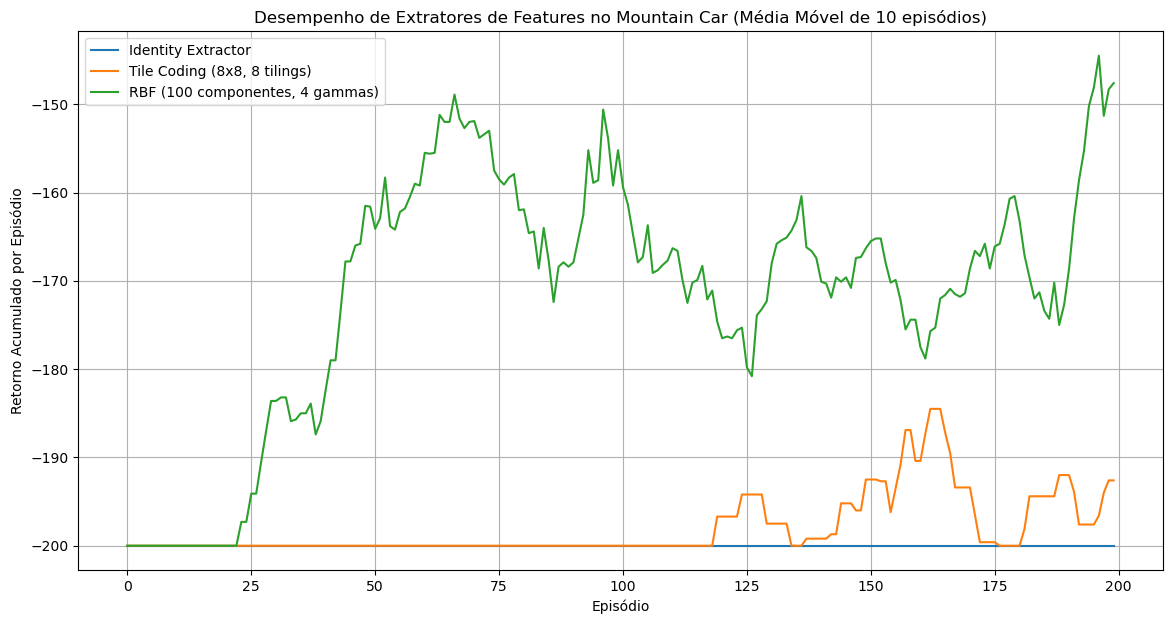

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Define o tamanho da janela da média móvel para suavizar as curvas
window_size = 10

# Calcula a média móvel para cada agente
identity_smooth = pd.Series(identity_agent).rolling(window_size, min_periods=1).mean()
tile_smooth = pd.Series(tile_agent).rolling(window_size, min_periods=1).mean()
rbf_smooth = pd.Series(rbf_agent).rolling(window_size, min_periods=1).mean()

# Cria o gráfico
plt.figure(figsize=(14, 7))
plt.plot(identity_smooth, label='Identity Extractor')
plt.plot(tile_smooth, label='Tile Coding (8x8, 8 tilings)')
plt.plot(rbf_smooth, label='RBF (100 componentes, 4 gammas)')

# Adiciona títulos, rótulos e legenda
plt.title(f'Desempenho de Extratores de Features no Mountain Car (Média Móvel de {window_size} episódios)')
plt.xlabel('Episódio')
plt.ylabel('Retorno Acumulado por Episódio')
plt.legend()
plt.grid(True)
plt.show()

13. Explique por que a modelagem do construtor de features pode ser crucial para o desempenho de um agente que utiliza aproximação de função.

YOUR ANSWER HERE

14. Quais critérios devem guiar a escolha dos modelos e da quantidade de features a serem utilizadas na construção do espaço de features?

YOUR ANSWER HERE